This notebook is recreating a [tutorial](http://www.degeneratestate.org/posts/2017/May/05/turing-patterns/) that describes how to solve PDE's, specifically turing PDE's. This method doesn't use sympy or any other function library for DE solving.

This tutorial walks through 1D simulation, 2D simulation and model analysis. However, the code provided implements an outdated gif framework. Therefore, I will implement the simulations and use [this tutorial](https://towardsdatascience.com/basics-of-gifs-with-pythons-matplotlib-54dd544b6f30) guidance on a different gif tool.

Using gifs to plot simulations is very useful and will make it easier when I am modelling biofilms.

- Turing Patterns
    - Turing showed that chemical reactions where each reactant has a different diffusion speed can produce interesting spatial patterns.
- Reaction Diffusion Equations
    - Reactions that very in time and space need to implement partial differential equations (PDE's) to be modelled, and take the form:
      \begin{align}
          \frac{\partial a(x,t)}{\partial t} =& D_a\frac{\partial^2 a(x,t)}{\partial x^2} + R_a\bigg(a(x,t),b(x,t)\bigg) \\
          \frac{\partial b(x,t)}{\partial t} =& D_b\frac{\partial^2 b(x,t)}{\partial x^2} + R_b\bigg(a(x,t),b(x,t)\bigg) \\
      \end{align}
- 


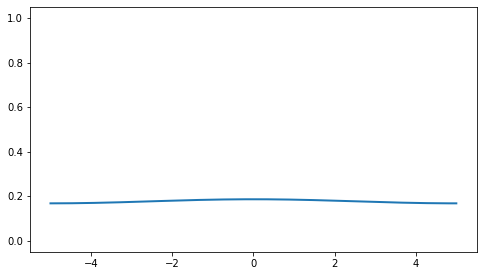

In [28]:
"""
Matplotlib Animation Example

author: Jake Vanderplas
email: vanderplas@astro.washington.edu
website: http://jakevdp.github.com
license: BSD
Please feel free to use and modify this, but keep the above information. Thanks!
"""

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
import ffmpeg



width = 1000
dx = 10/width
D = 1
dt = 0.9*(dx**2)/(2*D)

x = np.linspace(-5, 5, width)
y = np.exp(-x**2)

# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure(figsize = (16/2,9/2))
ax = plt.axes()
line, = ax.plot(x, y, lw=2)

def laplacian1D(a, dx):
    return (
        - 2 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
    ) / (dx ** 2)

# initialization function: plot the background of each frame
def init():
    line.set_data(x, y)
    return line,

# animation function.  This is called sequentially
def animate(i):
    global y, x
    for iteration in range(1000):
        y = y + dt*(laplacian1D(y, dx)*D)
    line.set_data(x, y)
    return line,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=200, interval=1, blit=False)

# save the animation as an mp4.  This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=30, dpi=100,  extra_args=['-vcodec', 'libx264'])

plt.show()

In [29]:
from IPython.display import Video

Video("basic_animation.mp4")

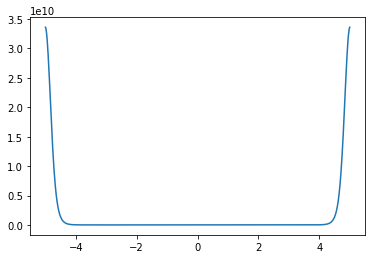

In [17]:
plt.plot(x,y)

In [18]:
dx

0.01

In [30]:
"""
Some utility functions for blog post on Turing Patterns.
"""

import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np

class BaseStateSystem:
    """
    Base object for "State System".
    We are going to repeatedly visualise systems which are Markovian:
    the have a "state", the state evolves in discrete steps, and the next
    state only depends on the previous state.
    To make things simple, I'm going to use this class as an interface.
    """
    def __init__(self):
        raise NotImplementedError()

    def initialise(self):
        raise NotImplementedError()

    def initialise_figure(self):
        fig, ax = plt.subplots()
        return fig, ax

    def update(self):
        raise NotImplementedError()

    def draw(self, ax):
        raise NotImplementedError()

    def plot_time_evolution(self, filename, n_steps=30):
        """
        Creates a gif from the time evolution of a basic state syste.
        """
        self.initialise()
        fig, ax = self.initialise_figure()

        def step(t):
            self.update()
            self.draw(ax)

        anim = animation.FuncAnimation(fig, step, frames=np.arange(n_steps), interval=20)
        anim.save(filename=filename, dpi=60, fps=10, writer='imagemagick')
        plt.close()
        
    def plot_evolution_outcome(self, filename, n_steps):
        """
        Evolves and save the outcome of evolving the system for n_steps
        """
        self.initialise()
        fig, ax = self.initialise_figure()
        
        for _ in range(n_steps):
            self.update()

        self.draw(ax)
        fig.savefig(filename)
        plt.close()

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# I'm using seaborn for it's fantastic default styles
import seaborn as sns
sns.set_style("whitegrid")

%matplotlib inline
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
def laplacian1D(a, dx):
    return (
        - 2 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
    ) / (dx ** 2)

def laplacian2D(a, dx):
    return (
        - 4 * a
        + np.roll(a,1,axis=0) 
        + np.roll(a,-1,axis=0)
        + np.roll(a,+1,axis=1)
        + np.roll(a,-1,axis=1)
    ) / (dx ** 2)

In [40]:
class OneDimensionalDiffusionEquation(BaseStateSystem):
    def __init__(self, D):
        self.D = D
        self.width = 1000
        self.dx = 10 / self.width
        self.dt = 0.9 * (self.dx ** 2) / (2 * D)
        self.steps = int(0.1 / self.dt)
        
    def initialise(self):
        self.t = 0
        self.X = np.linspace(-5,5,self.width)
        self.a = np.exp(-self.X**2)
        
    def update(self):
        for _ in range(self.steps):
            self.t += self.dt
            self._update()

    def _update(self):      
        La = laplacian1D(self.a, self.dx)
        delta_a = self.dt * (self.D * La)       
        self.a += delta_a
        
    def draw(self, ax):
        ax.clear()
        ax.plot(self.X,self.a, color="r")
        ax.set_ylim(0,1)
        ax.set_xlim(-5,5)
        ax.set_title("t = {:.2f}".format(self.t))
    
one_d_diffusion = OneDimensionalDiffusionEquation(D=1)

one_d_diffusion.plot_time_evolution("diffusion.gif")

MovieWriter imagemagick unavailable; using Pillow instead.


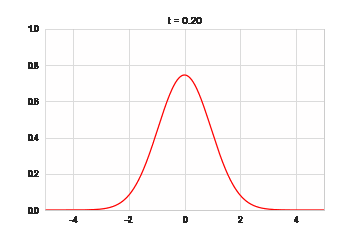

In [41]:
from IPython.display import Image
with open('diffusion.gif','rb') as file:
    display(Image(file.read()))

In [39]:
print(1_000_000)

1000000
